porownanie globalne, animcaja od lat ok 60, zrobienie algorytmu ktory sprawdza nagle spadki (srednia rkoczaca czy cos) ktory wyrzuca nagle anomalie (bezwzgl wartosci pkb). potem sprawdzic co wtedy bylo

podzial na zwykjle i percapita

algorytm wykrywajacy anomalie

uwzglednienie podzialu na kategorie kraju

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches

Wczytanie gpd <br>
bez kolumn indicator name i indicator code informujące o przedstawianiu pkb przy pomocy dolarów  (GDP per capita (current US$)	i NY.GDP.PCAP.CD)<br>
drop 2024 ponieważ są tam same Nan

In [44]:
gdp = pd.read_excel('gdp.xls', sheet_name='Data', skiprows=3)
gdp = gdp.drop(columns=['Indicator Name', 'Indicator Code','2024'])

In [45]:
gdp_per_capita = pd.read_excel('gdp_per_capita.xls', sheet_name='Data', skiprows=3)
gdp_per_capita = gdp_per_capita.drop(columns=['Indicator Name', 'Indicator Code','2024'])

Informacje o tym do jakiej grupy przychodowej zakategoryzowano dane kraje

In [46]:
metadata = pd.read_excel('gdp.xls', sheet_name='Metadata - Countries')
metadata = metadata[['Country Code','IncomeGroup','Region']]

Join metadanych do kolumn 

In [47]:
data = pd.merge(gdp, metadata, on='Country Code', how='left')

In [48]:
data_pc = pd.merge(gdp_per_capita, metadata, on='Country Code', how='left')

https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

In [49]:
world1 = gpd.read_file("shape/ne_110m_admin_0_countries.shp")
world1 = world1[['ADMIN','SOV_A3','geometry']]
world1 = world1.rename(columns={'ADMIN': 'Country Name', 'SOV_A3': 'Country Code'})

"https://github.com/datasets/geo-countries/raw/main/data/countries.geojson"

In [50]:
world2 = gpd.read_file("https://github.com/datasets/geo-countries/raw/main/data/countries.geojson")
world2 = world2[['name','ISO3166-1-Alpha-3','geometry']]
world2 = world2.rename(columns={'name': 'Country Name', 'ISO3166-1-Alpha-3': 'Country Code'})
world2 = world2[world2['Country Code'] != '-99']

Z istotnych krajów Brakuje Francji

https://github.com/georgique/world-geojson/blob/develop/countries/france.json

In [51]:
franceshp = gpd.read_file("shape/france.json")
franceshp = franceshp.dissolve()
franceshp = franceshp.to_crs(world2.crs)
franceshp['Country Code'] = 'FRA'
france_row = franceshp[['Country Code', 'geometry']]
france_row = france_row.reset_index(drop=True)

world2 = pd.concat([world2, france_row], ignore_index=True)


In [52]:
world = pd.concat([world1, world2]).drop_duplicates(subset='Country Code').reset_index(drop=True)
world = world[['Country Code','geometry']]

In [53]:
data = pd.merge(world, data, on='Country Code', how='left')
data_pc = pd.merge(world, data_pc, on='Country Code', how='left')
data.head(3)

,Country Code,geometry,Country Name,1960,1961,1962,1963,1964,1965,1966,...,2016,2017,2018,2019,2020,2021,2022,2023,IncomeGroup,Region
0,FJI,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",Fiji,1.123284e+08,1.169878e+08,1.229064e+08,1.294547e+08,1.400327e+08,1.470848e+08,1.506039e+08,...,4.930214e+09,5.353469e+09,5.581425e+09,5.444407e+09,4.432466e+09,4.305032e+09,4.969504e+09,5.442047e+09,Upper middle income,East Asia & Pacific
1,TZA,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...",Tanzania,2.651730e+09,2.826179e+09,3.101590e+09,3.456579e+09,3.748841e+09,3.817227e+09,4.377999e+09,...,4.977441e+10,5.327488e+10,5.700371e+10,6.102673e+10,6.606874e+10,7.065563e+10,7.576997e+10,7.906240e+10,Lower middle income,Sub-Saharan Africa
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
data_pc.head(3)

,Country Code,geometry,Country Name,1960,1961,1962,1963,1964,1965,1966,...,2016,2017,2018,2019,2020,2021,2022,2023,IncomeGroup,Region
0,FJI,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",Fiji,277.431535,280.273367,285.473073,291.383574,305.532203,311.241073,309.574409,...,5363.790256,5826.848141,6085.419792,5950.828686,4844.421290,4696.171019,5405.030074,5888.736686,Upper middle income,East Asia & Pacific
1,TZA,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...",Tanzania,275.296021,285.156799,303.997437,329.010590,346.301819,342.077942,380.497925,...,953.010742,986.674011,1023.106262,1063.322510,1117.415283,1159.856567,1207.853027,1224.489624,Lower middle income,Sub-Saharan Africa
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[]

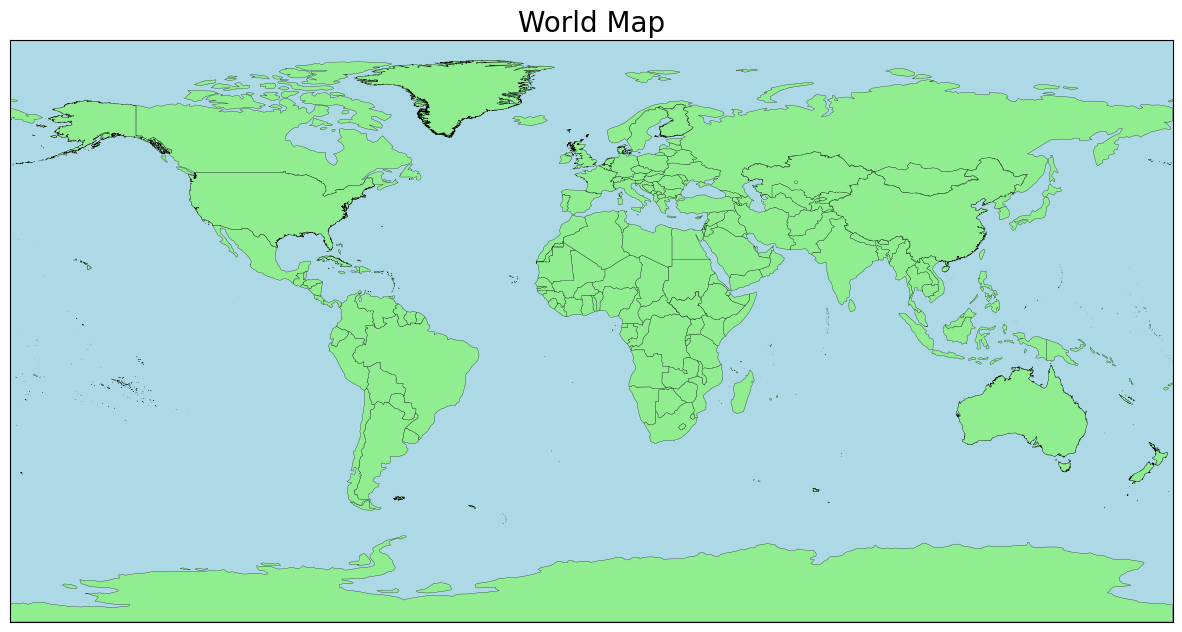

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
data.plot( ax=ax, color='lightgreen',  edgecolor='black', linewidth=0.2)
ax.set_facecolor('lightblue')
ax.set_title('World Map', fontsize=20)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_xticks([])
ax.set_yticks([])

Posiadamy DataFrame Zawierający:<br>
-Kod Kraju<br>
-geometrie na mapie Świata<br>
-Nazwe Kraju<br>
-Dane na temat Pkb od 1960-2023<br>
-Kategorię grupy dochodowej kraju<br>

kolory do plotu income groups

In [56]:
data['IncomeGroup'] = data['IncomeGroup'].fillna('Unknown')

legend_colors = {
    'Low income': 'red',
    'Lower middle income': 'orange',
    'Upper middle income': 'yellow',
    'High income': 'green',
    'Unknown': 'grey'
}
data['color'] = data['IncomeGroup'].map(legend_colors)


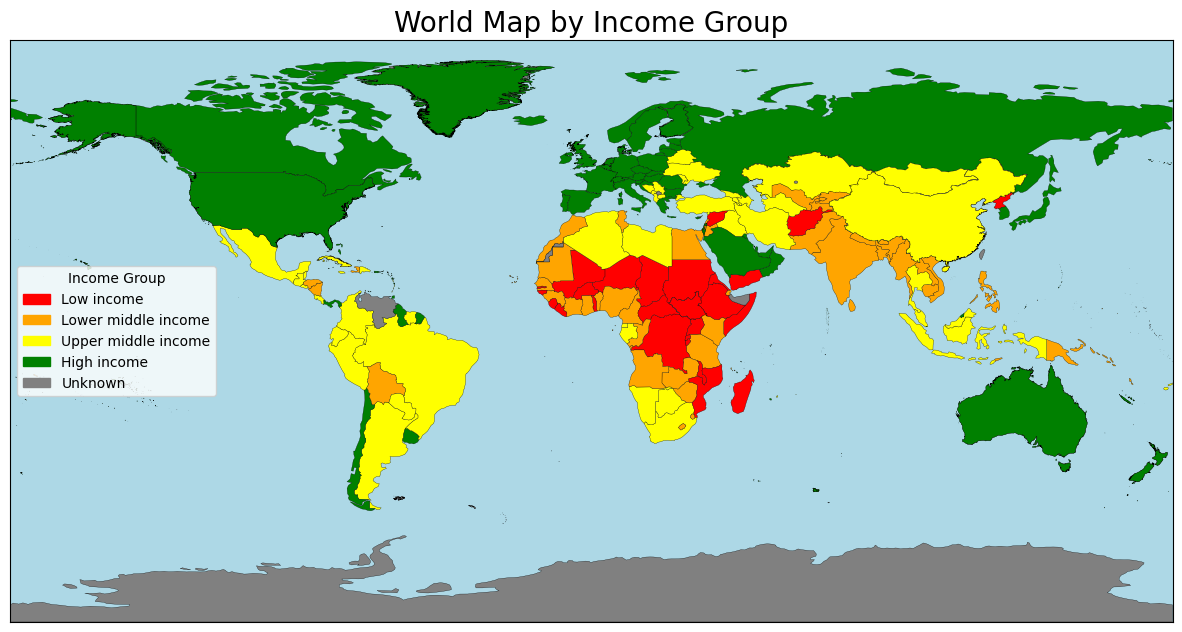

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
data.plot(ax=ax, color=data['color'], edgecolor='black', linewidth=0.2)
ax.set_facecolor('lightblue')
ax.set_title('World Map by Income Group', fontsize=20)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_xticks([])
ax.set_yticks([])


handles = [mpatches.Patch(color=color, label=group) for group, color in legend_colors.items()]
ax.legend(handles=handles, title='Income Group', loc='center left')

[]

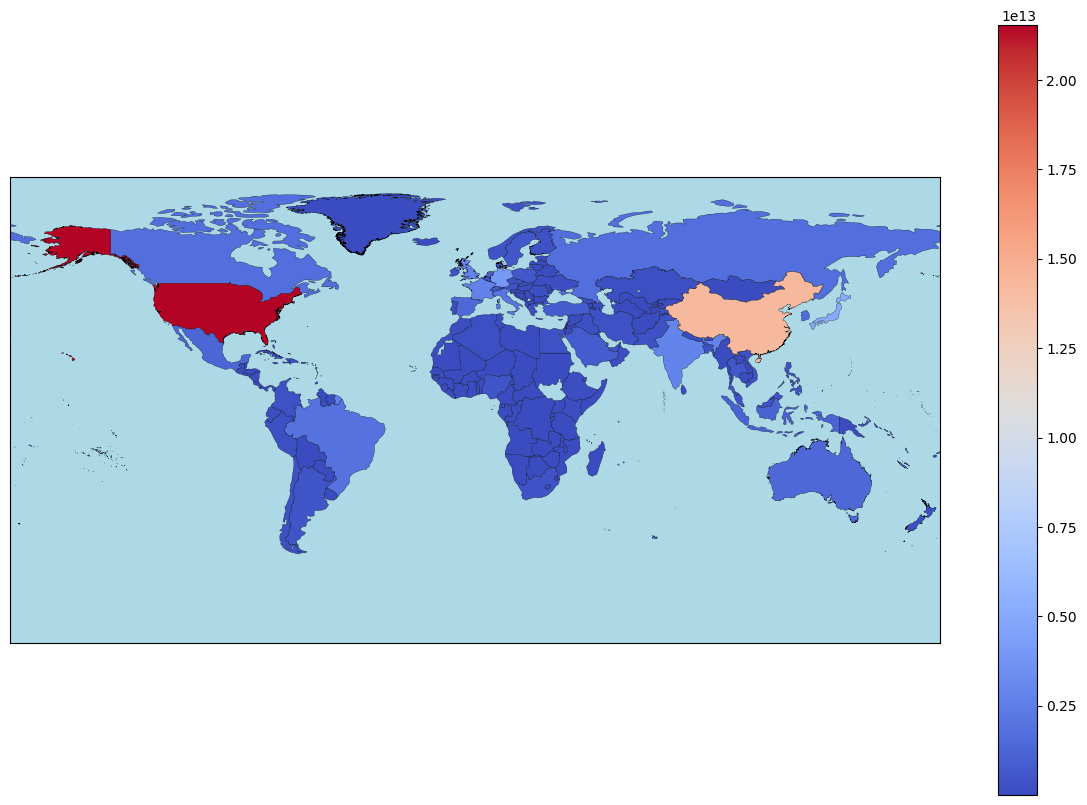

In [86]:
#create data without us and china
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
data.plot(ax=ax, column='2019', edgecolor='black', cmap='coolwarm', linewidth=0.2,legend=True)
ax.set_facecolor('lightblue')
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_xticks([])
ax.set_yticks([])